# Final year forecasting

## Setup and data loading

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from script import *
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '../data/405.txt'
OUTPUT_PATH = '../data/predictions.csv'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


### Create index and select feature columns

In [3]:
data.crossTime.is_unique

False

In [4]:
duplicates = data[data.duplicated()]
duplicates

,crossTime,speed,weight
1027596,2013-01-11 16:27:18.500,88,8260
1246476,2013-06-18 18:36:40.600,86,11190
1670099,2015-07-27 12:41:01.600,89,3530
1751529,2015-09-15 14:22:54.900,81,5470
2246137,2016-07-22 12:58:58.200,25,3590
2710589,2017-06-23 18:05:58.100,90,3580
3355905,2018-07-17 08:53:27.400,90,16470


Duplicates are simply mulitple vehicles in same timespan. Will be counted in resampling, we can ignore them for now.

## Feature engineering

In [18]:
def year_splitter(data, val_years=2, test_years=2):
    # Consider year as discrete number of weeks
    weeks_in_year = 52
    days_in_year = 7 * weeks_in_year
    year_delta = pd.Timedelta(f"{days_in_year} days")
    
    test_split = data.index.max() - test_years * year_delta
    val_split = test_split - val_years * year_delta
    
    return data[:val_split], data[val_split:test_split], data[test_split:]

In [19]:
def pipeline(sampling_interval):
    
    feature_cols = [col for col in data.columns if col != 'crossTime']
    features = data[feature_cols]
    features.index = data.crossTime
            
    # Truncate data to have ignore COVID pandemic 
    start_of_covid = "2019-10-21"
    features = features.truncate(after=start_of_covid)

    # Downsample and add vehicle counts
    resampled = features.resample(sampling_interval)
    features = resampled.sum()
    features['n_vehicles'] = resampled.size()
        
    ## FEATURE ENGINEERING
    
    # HGV movement restrictions #
    legal_driving_start = 5
    legal_driving_end = 22
    legal_driving_duration = legal_driving_end - legal_driving_start
    sunday = 6
    
    dayofweek = pd.Series(features.index.dayofweek, index=features.index)
    hours = pd.Series(features.index.hour, index=features.index)
    shifted_hours = hours - legal_driving_start
    
    features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
    
    # Time periodicity features #
    # Transform to seconds
    timestamp_s = features.index.map(pd.Timestamp.timestamp)

    # Corresponding length in seconds for day, week, year
    minute_s = 60
    hour_s = minute_s * 60
    day_s = 24 * hour_s # 24h x 60m x 60s
    week_s = 7 * day_s
    year_s = 365.2425 * day_s
    
    # Add sin/cos periodicity columns to features dataframe
    def add_time_period_cols(time_length, time_string):
        features[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
        features[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))

    add_time_period_cols(day_s, 'day')
    add_time_period_cols(week_s, 'week')
    add_time_period_cols(year_s, 'year')    
    
    # Split data giving 2y to test and val each, then normalize data with training set
    return split_norm_data(features, return_mean_std=True, splitter=year_splitter)

In [20]:
train, val, test, train_mean, train_std = pipeline('1h')
num_features = len(train.columns)

## Model prediction

### Windowing 

In [21]:
WEEK_STEPS = 7 * 24
YEAR_STEPS = 52 * WEEK_STEPS
SHIFT_STEPS = YEAR_STEPS      # predict same week of following year

week_window = make_window(train, val, test, train_mean, train_std,
                          input_w=WEEK_STEPS, label_w=WEEK_STEPS,
                          shift=SHIFT_STEPS, label_cols=train.columns.to_list())
week_window

Total window size: 8904
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [8736 8737 8738 8739 8740 8741 8742 8743 8744 8745 8746 8747 8748 8749
 8750 8751 8752 8753 8754 8755 8756 8757 8758 8759 8760 8761 8762 8763
 8764 8765 8766 8767 8768 8769 8770 8771 8772 8773 8774 8775 8776 8777
 8778 8779 8780 8781 8782 8783 8784 8785 8786 8787

<Figure size 800x600 with 0 Axes>

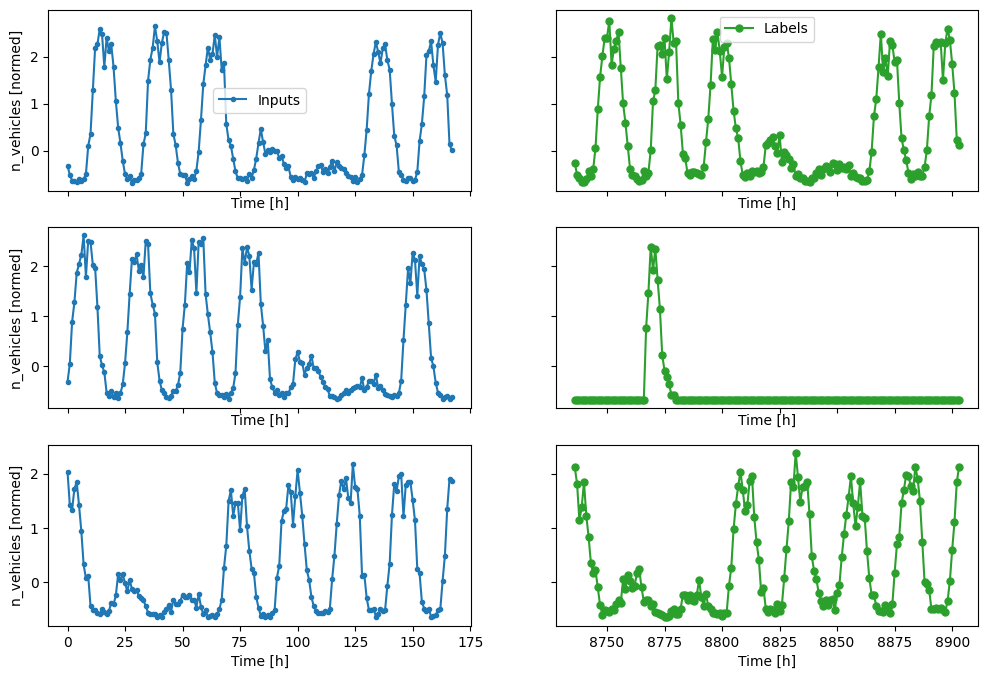

In [23]:
week_window.plot()
plt.show()
plt.clf()

### Model creation

In [24]:
rnn = lstm_model(num_features)
history = compile_and_fit(rnn, week_window)

Epoch 1/20
346/346 [==============================] - 13s 31ms/step - loss: 0.2567 - mean_absolute_error: 0.3196 - val_loss: 0.1060 - val_mean_absolute_error: 0.1641
Epoch 2/20
346/346 [==============================] - 10s 29ms/step - loss: 0.0814 - mean_absolute_error: 0.1395 - val_loss: 0.0950 - val_mean_absolute_error: 0.1333
Epoch 3/20
346/346 [==============================] - 11s 30ms/step - loss: 0.0707 - mean_absolute_error: 0.1167 - val_loss: 0.0902 - val_mean_absolute_error: 0.1196
Epoch 4/20
346/346 [==============================] - 11s 31ms/step - loss: 0.0665 - mean_absolute_error: 0.1060 - val_loss: 0.0905 - val_mean_absolute_error: 0.1129
Epoch 5/20
346/346 [==============================] - 11s 31ms/step - loss: 0.0641 - mean_absolute_error: 0.0999 - val_loss: 0.0898 - val_mean_absolute_error: 0.1094
Epoch 6/20
346/346 [==============================] - 11s 30ms/step - loss: 0.0624 - mean_absolute_error: 0.0965 - val_loss: 0.0898 - val_mean_absolute_error: 0.1069
Epoc

<Figure size 800x600 with 0 Axes>

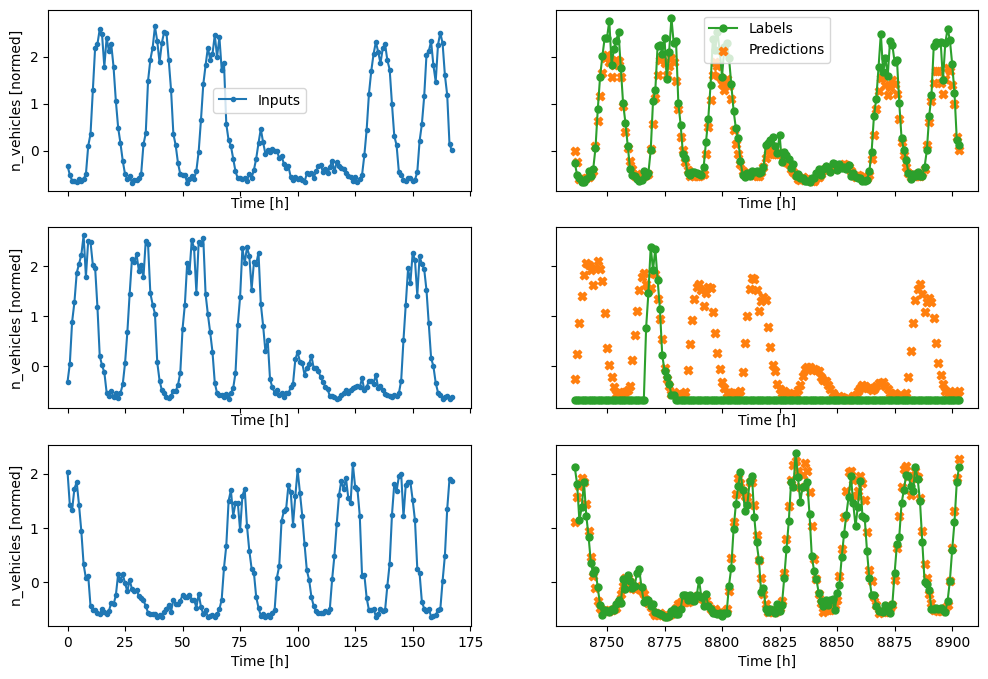

In [25]:
fig = week_window.plot(rnn)
plt.show()

In [26]:
rnn.save("lstm_year_gap")

INFO:tensorflow:Assets written to: lstm_year_gap/assets


INFO:tensorflow:Assets written to: lstm_year_gap/assets


### Prediction dataset

In [27]:
test_tf = week_window.make_dataset(test, training=False)
test_in, test_out = next(iter(test_tf))

Sanity check: check that the batches correspond to the correct weeks

In [28]:
for i, (in_tf, out_tf) in enumerate(zip(test_in, test_out)):        
    inputs = pd.DataFrame(in_tf.numpy(), columns=test.columns)
    pd_inputs = test.iloc[week_window.input_indices + i * week_window.input_width]
    pd_inputs = pd_inputs.reset_index().drop(columns='crossTime').astype('float32')
    
    outputs = pd.DataFrame(out_tf.numpy(), columns=test.columns)
    pd_outputs = test.iloc[week_window.label_indices + i * week_window.input_width]
    pd_outputs = pd_outputs.reset_index().drop(columns='crossTime').astype('float32')

    pd.testing.assert_frame_equal(outputs, pd_outputs)
    pd.testing.assert_frame_equal(outputs, pd_outputs)

Make predictions then stack results

In [42]:
predictions = rnn(test_in)
weeks, hours, features = predictions.shape

predictions.shape

TensorShape([52, 168, 10])

In [43]:
predictions = tf.reshape(predictions, (weeks*hours, features)).numpy()
predictions.shape

(8736, 10)

In [44]:
test.iloc[week_window.label_start:-1].index

DatetimeIndex(['2018-10-21 23:00:00', '2018-10-22 00:00:00',
               '2018-10-22 01:00:00', '2018-10-22 02:00:00',
               '2018-10-22 03:00:00', '2018-10-22 04:00:00',
               '2018-10-22 05:00:00', '2018-10-22 06:00:00',
               '2018-10-22 07:00:00', '2018-10-22 08:00:00',
               ...
               '2019-10-20 13:00:00', '2019-10-20 14:00:00',
               '2019-10-20 15:00:00', '2019-10-20 16:00:00',
               '2019-10-20 17:00:00', '2019-10-20 18:00:00',
               '2019-10-20 19:00:00', '2019-10-20 20:00:00',
               '2019-10-20 21:00:00', '2019-10-20 22:00:00'],
              dtype='datetime64[ns]', name='crossTime', length=8736, freq='H')

In [45]:
index = test.iloc[week_window.label_start:-1].index
predictions = pd.DataFrame(predictions, columns=test.columns, index=index)

In [46]:
predictions

,speed,weight,n_vehicles,is_legal,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
crossTime,,,,,,,,,,
2018-10-21 23:00:00,-0.329648,-0.365480,-0.380710,-1.278627,0.029561,0.838816,-0.267357,-0.498864,-0.511952,0.314680
2018-10-22 00:00:00,-0.492578,-0.489207,-0.512570,-1.643864,0.106923,1.242422,-0.568714,-0.930049,-0.998304,0.473418
2018-10-22 01:00:00,-0.568568,-0.531221,-0.587937,-1.635302,0.343899,1.336201,-0.706476,-1.154634,-1.263125,0.566370
2018-10-22 02:00:00,-0.602230,-0.539888,-0.635218,-1.598538,0.661630,1.242406,-0.776313,-1.239733,-1.368033,0.607127
2018-10-22 03:00:00,-0.585776,-0.508984,-0.627684,-1.567158,0.988714,1.018947,-0.820206,-1.249196,-1.369280,0.616123
...,...,...,...,...,...,...,...,...,...,...
2019-10-20 18:00:00,-0.383005,-0.443490,-0.346907,0.632386,-1.459927,-0.030800,-0.351220,-1.406591,-1.358157,0.513173
2019-10-20 19:00:00,-0.419856,-0.470659,-0.398825,0.622820,-1.391753,0.382825,-0.408089,-1.415185,-1.351316,0.528046
2019-10-20 20:00:00,-0.478756,-0.522162,-0.478664,0.622146,-1.230541,0.778895,-0.468807,-1.438915,-1.349930,0.542262


## Performance evaluation and data generation

### Plotting results

In [48]:
def plot_week(predictions, week_number, test=test, save_to=None):
    fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)

    for i, (col, ax) in enumerate(zip(test.columns, axs.flatten())):
        ax.set_title(col)
        ax.set_xlabel('Day of crossing [days]')
    
        label_indices = week_window.label_indices + week_window.label_width * week_number
        input_indices = week_window.input_indices + week_window.input_width * week_number
        
        test.iloc[label_indices][col].plot(ax=ax, label='actual')
        predictions.iloc[input_indices][col].plot(ax=ax, label='predicted')

        if i == 1:
            ax.legend()
            
    if save_to:
        fig.savefig(save_to)
    
    fig.show()


<Figure size 800x600 with 0 Axes>

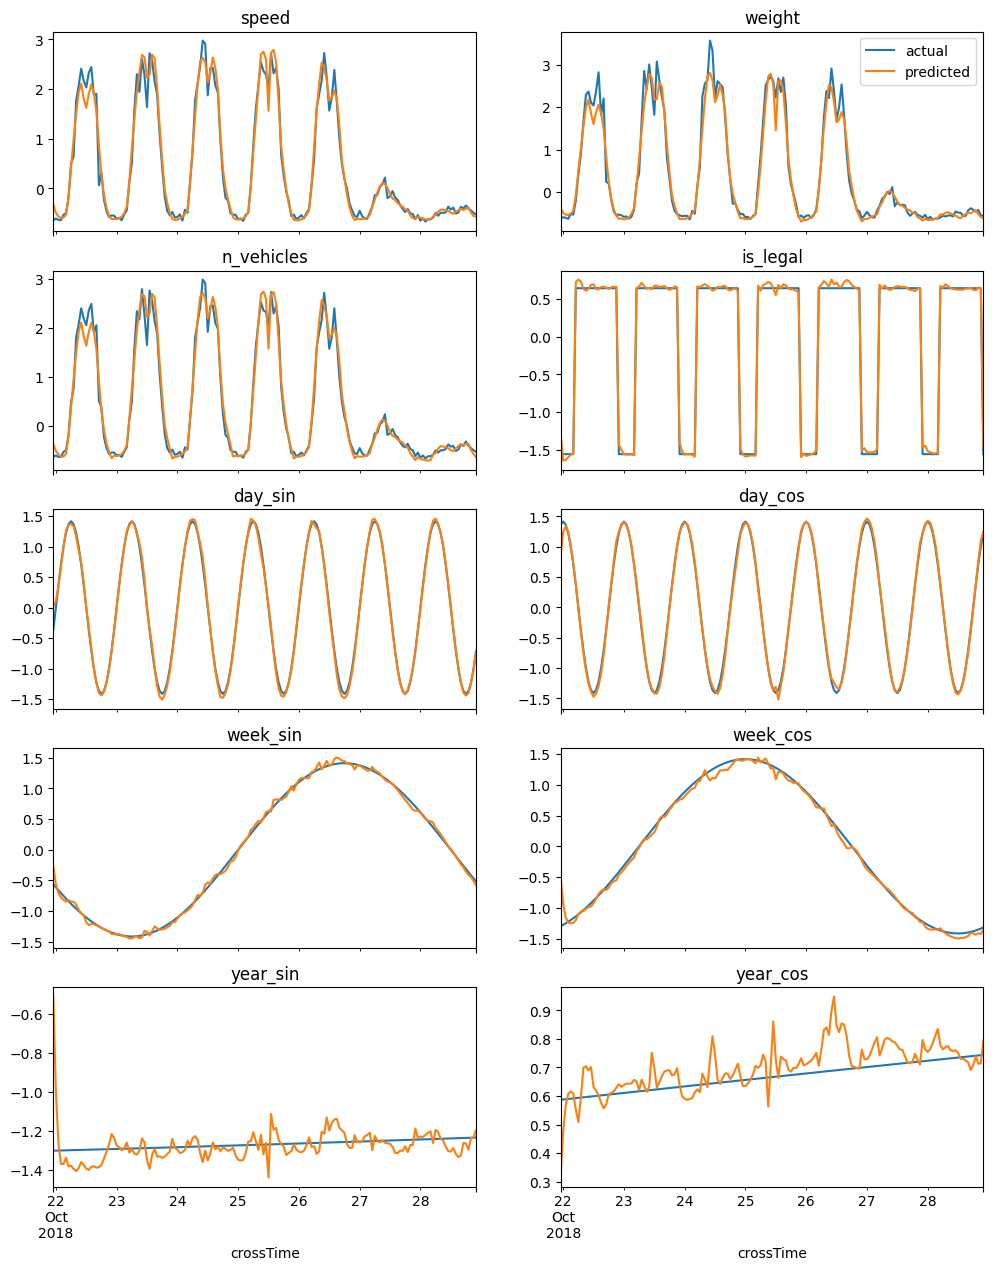

In [51]:
plot_week(predictions, 1)
plt.show()
plt.clf()

### Evaluating performance

In [52]:
_, mae = rnn.evaluate(test_tf)

print(f"We get a mean absolute error of {mae} on our predicted dataset")

1/1 [==============================] - 0s 108ms/step - loss: 0.0865 - mean_absolute_error: 0.1128
We get a mean absolute error of 0.11280845105648041 on our predicted dataset


### Data creation

In [53]:
def denormalize(data, mean=train_mean, std=train_std):
    data = data.copy()
    data = data * std + mean
    
    data['n_vehicles'] = data['n_vehicles'].round()
    data['is_legal'] = (data['is_legal'] > 0.5).astype(int)
    
    return data

In [54]:
de_predictions = denormalize(predictions)

<Figure size 800x600 with 0 Axes>

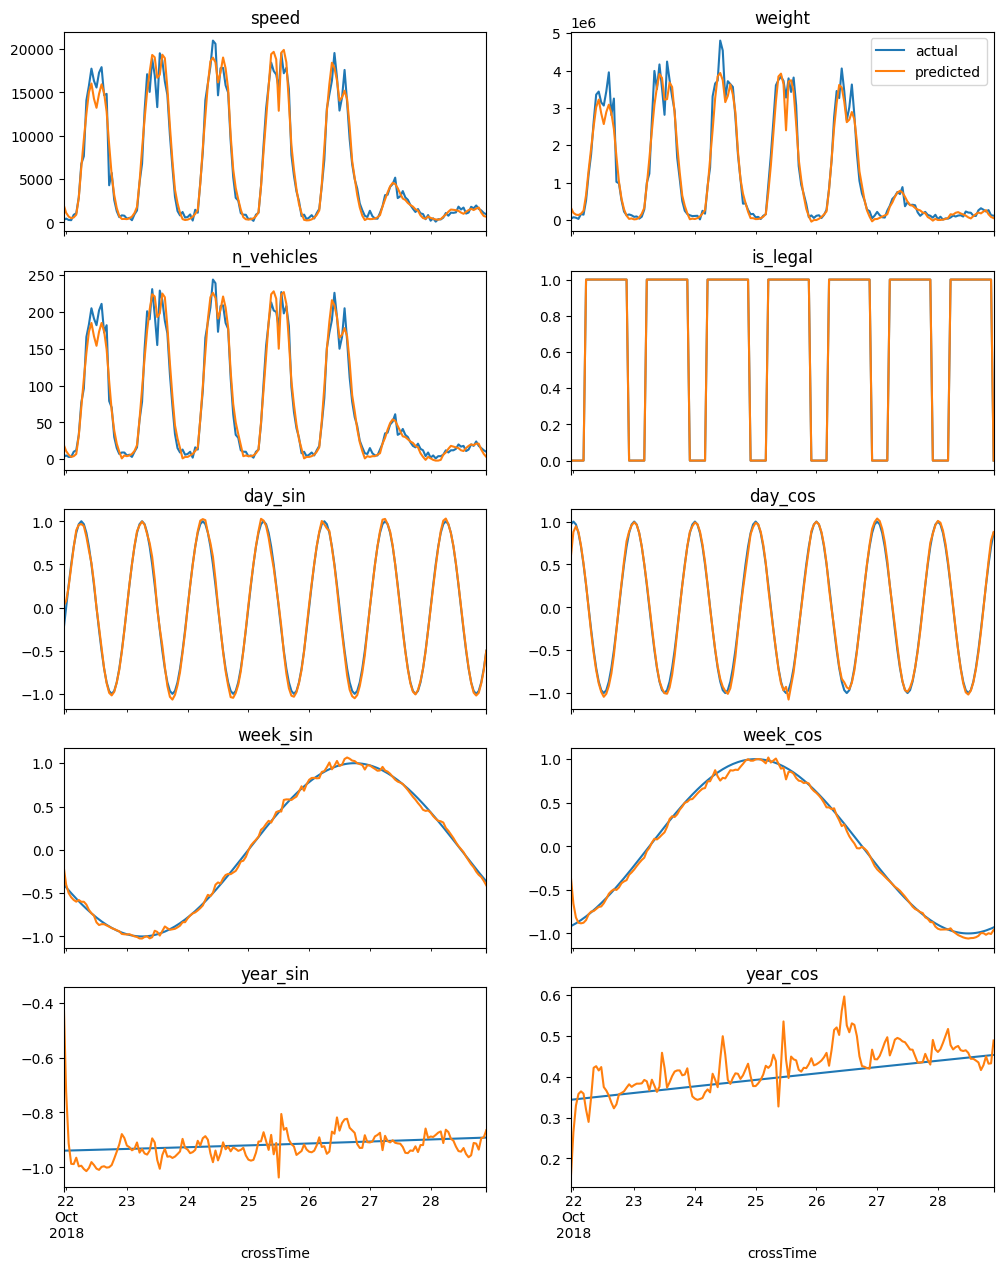

In [57]:
plot_week(de_predictions, 1, test=denormalize(test))
plt.show()
plt.clf()

In [58]:
de_predictions.to_csv(OUTPUT_PATH)